# Welch's Method

Similar to the method used by Cuki and the initial method used by myself ("block processing").

Resources:
- [Welch's Method - Wikipedia](https://en.wikipedia.org/wiki/Welch%27s_method)
- [Nonparametric Methods - MathWorks](https://www.mathworks.com/help/signal/ug/nonparametric-methods.html)
- [csd - scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html)
- [welch - scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

import scipy.signal
from IPython.display import display, Audio

In [8]:
INPUT_FILE = "data/martin_dcx1re_c414_left_pickup_right.wav"
# INPUT_FILE = "data/martin_dcx1re_cm4_left_pickup_right.wav"
# INPUT_FILE = "data/martin_dcx1re_lct140_left_pickup_right.wav"

In [9]:
data, sample_rate_Hz = sf.read(INPUT_FILE)
ydata, xdata = data.T

In [10]:
def freqresp(H, fig, ax1, ax2):
    f = np.linspace(0, sample_rate_Hz, len(H))
    end = len(f)//2
    f_ = f[0:end]
    ax1.semilogx(f_, 20*np.log10(np.abs(H[0:end])))
    ax2.semilogx(f_, np.rad2deg(np.unwrap(np.angle(H[0:end]))))
      
    for ax in (ax1, ax2):
        ax.grid()
    fig.tight_layout()


## Naive deconvolution

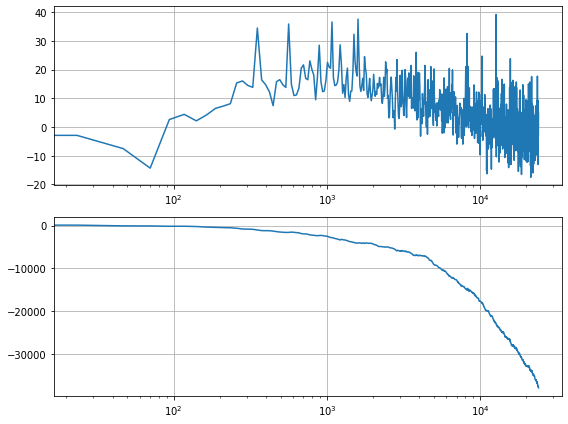

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

w = np.hanning(len(xdata))
X = np.fft.fft(w * xdata, LENGTH)
Y = np.fft.fft(w * ydata, LENGTH)
H_naive = Y/X

freqresp(H_naive, fig, ax1, ax2)

## Welch's method

In [41]:
def tfestimate(x, y, **kwargs):
    _, Pxx = scipy.signal.welch(x, **kwargs)
    _, Pyx = scipy.signal.csd(x, y, **kwargs)
    H = Pyx/Pxx
    return H

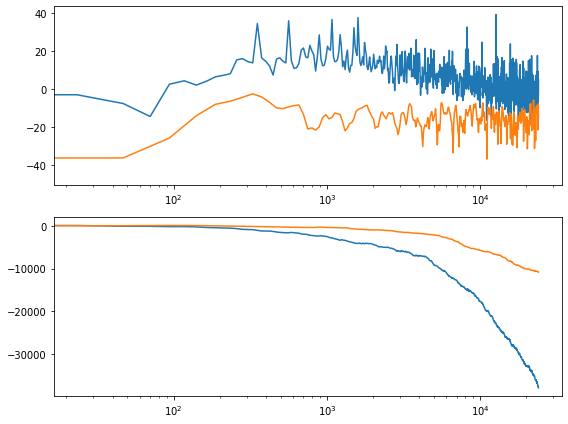

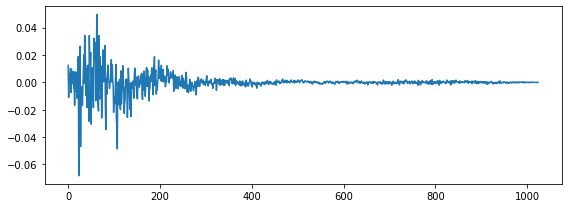

In [74]:
H = tfestimate(xdata, ydata, nperseg=2048, noverlap=None, window="hanning", average="mean")
h = np.real(np.fft.ifft(H))
n = np.arange(len(h))
fade = (-n + len(n))/len(n)
h *= fade
H = np.fft.fft(h)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
freqresp(H_naive, fig, ax1, ax2)
freqresp(H, fig, ax1, ax2)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(h)
fig.tight_layout()

In [ ]:
# Convolve with the pickup signal
ydata_estimate = np.convolve(xdata, h)

sf.write("_output.wav", ydata_estimate, samplerate=sample_rate_Hz)
display(Audio("_output.wav"))

In [ ]:
sf.write("_pickup.wav", xdata, samplerate=sample_rate_Hz)
display(Audio("_pickup.wav"))

sf.write("_microphone.wav", ydata, samplerate=sample_rate_Hz)
display(Audio("_microphone.wav"))

## Conclusion

This does not look correct. There is almost no frequency-dependency except at DC.